In [43]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import auc

from tqdm import tqdm # pretty progress bar
import weles as ws

import seaborn as sn
import matplotlib.cm as cm

# setup
plt.style.use('default')

# Load Dataset

In [95]:
df_dataset = "<my-dataset>.csv"

In [96]:
df_dataset = pd.read_csv(df_dataset, delimiter=",")

In [97]:
df_dataset = df_dataset.sample(frac=1).reset_index(drop=True)

In [98]:
df_dataset.rename(columns = {'Label':'label'}, inplace = True)

df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
df_dataset = df_dataset.dropna()

In [99]:
y_1 = df_dataset ['label']
X_1 = df_dataset.drop(columns=['label'])
y_1 = y_1.astype('category')
y_1 = y_1.cat.codes

# Get Init Info

In [100]:
print(df_multiclass_orig["label"].value_counts())

BENIGN              439683
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: label, dtype: int64


In [101]:
# Stats
print("Num. Features:",len(X_1.columns))
print("Total Size:",len(X_1))
print("Duplicated Flows:",X_1[X_1.duplicated()].shape[0])

Num. Features: 78
Total Size: 691406
Duplicated Flows: 80961


In [68]:
from fet.explorer import Explorer
# NOTE: label column must be lowercase
e = Explorer(y='label')

In [69]:
e.df = df_multiclass_orig
e.feature_cols = list(X_1.columns) #feature_cols

In [70]:
e.feature_scores()[:10]

/home/dosoukup/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/dosoukup/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[('Bwd Packet Length Mean', 113214.46291705649),
 ('Bwd Packet Length Std', 109295.42220035593),
 ('Bwd Packet Length Max', 107147.27012081437),
 ('Fwd IAT Std', 103628.84758841556),
 ('Fwd IAT Max', 94766.41917069162),
 ('Flow IAT Max', 94368.1209242012),
 ('Flow IAT Std', 76019.45891699553),
 ('Fwd IAT Total', 47220.1980313275),
 ('Flow Duration', 46539.9699347709),
 ('Flow IAT Mean', 34719.63159810752)]

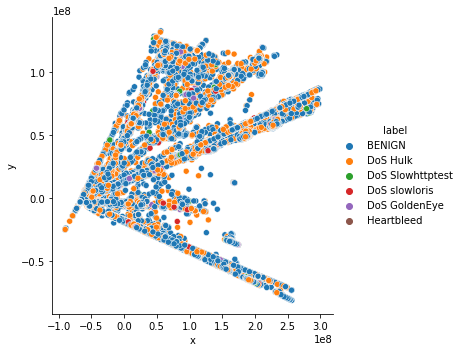

In [28]:
e.plot_pca()

In [87]:
import sklearn.metrics as metrics
auc = metrics.auc([0.5,1],[0.5,1])
print(auc)

0.375


# Test 1: Dataset Redundancy 

In [ ]:
## Description: This test verifies the amount of redundat data for selected classification model to provide the comparative results as complete dataset

## Input: 
### - X_1: Dataset features part
### - y_1: Dataset label part
### - runs: Number of iterations for random sampling
### - percentage: Levels of selections for training part
### - alfa: Level of acceptance
### - metric: Performance metric for ML classifiers
### - clfs: Pool of ML classifiers

## Output:
### - perc: First percentage level that work sufficiently for all "runs"
### - model: List of successful models for selected "perc"
### - score: Inverse of "perc" (final metric)



In [ ]:
from sklearn.metrics import precision_score, f1_score, recall_score
from imblearn.metrics import sensitivity_score, specificity_score

runs = 5 # number of iterations 
percentage = [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 0.9] # percentage of selection 
metric =  f1_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

clfs = {
        #"KNN": KNeighborsClassifier(),
        #"SVM": SVC(), #long time of processing; SVM is moved to the separated notebook
        #"GNB": GaussianNB(),
        "DT": DecisionTreeClassifier(criterion = "gini"),
        "RF": RandomForestClassifier(class_weight="balanced", criterion='gini'),
        #"AB": AdaBoostClassifier(),   
        "XGB": XGBClassifier(objective="multi:softmax"),
        #"MLP": MLPClassifier(max_iter=1000, hidden_layer_sizes=5, batch_size=100)
        #"DT": DecisionTreeClassifier(class_weight="balanced"),
        #"XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic",eval_metric="logloss")
}

In [ ]:
results = {}

for name, clf in clfs.items():
    l = []
    results[name] = [l.copy() for i in range(runs)]
    
for i in range(0,runs):
    for frac in tqdm(percentage):
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_1, y_1, test_size=1-frac, stratify=y_1, shuffle=True)
        for name, clf in clfs.items():
            clf.fit(X_train_sub, y_train_sub)
            pred = clf.predict(X_test_sub)
            results[name][i].append(metrics.f1_score(y_test_sub,pred,average="weighted"))


![Redundancy](redundancy.png)

In [ ]:
# Calculate Redundancy
score = {}
max_val = None
max_model = None

for name, clf in clfs.items(): 
    score[name] = {} 
    for i in range(0,runs):
        last = None
        for j in range(0,len(percentage)):
            try:
                score[name][percentage[j]].append(results[name][i][j])
            except Exception as e:
                score[name][percentage[j]] = [results[name][i][j]]
            try:
                if max_val < results[name][i][j]:
                    max_val = results[name][i][j]
                    max_model = name
            except Exception as e:
                max_val = results[name][i][j]
                max_model = name


In [ ]:
# Get Redundancy Score
limit = max_val*alfa
redundancy_score = {"perc":101,"model":[]}

for name, clf in clfs.items():
    for perc in percentage: 
        tmp = []
        for item in range(runs):
            if (max_val - score[name][perc][item]) < limit:
                tmp.append(score[name][perc][item])
        #print(perc, tmp)
        if len(tmp) == runs:
            if perc < redundancy_score["perc"]:
                redundancy_score["perc"] = perc
                redundancy_score["model"].append(name)
                
print(redundancy_score)
print("Metric Score",1-redundancy_score["perc"])

# Test 2: Dataset Association Quality

In [ ]:
## Description: This test verifes the level of relantionship between feature data and respective labels. The evaluation is enhanced for multiclassification and also the final metric is providing more reliable results.

## Input:
### - X_1: Dataset features part
### - y_1: Dataset label part
### - nperm: Number of permutation iterations
### - perc: Levels of selections for training part
### - metric: Performance metric for ML classifiers
### - clfs: Pool of ML classifiers

# Output:
### - ML model with highest slope and AUC ... TBD ...



In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_1 = MinMaxScaler().fit_transform(X_1)
datasets = {
    "all": (X_1, y_1)
}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

clfs = {
        #"KNN": KNeighborsClassifier(),
        #"SVM": SVC(), #long time of processing; SVM is moved to the separated notebook
        #"GNB": GaussianNB(),
        "DT": DecisionTreeClassifier(criterion = "gini"),
        "RF": RandomForestClassifier(class_weight="balanced", criterion='gini'),
        #"AB": AdaBoostClassifier(),   
        "XGB": XGBClassifier(objective="multi:softmax"),
        #"MLP": MLPClassifier(max_iter=1000, hidden_layer_sizes=5, batch_size=100)
        #"DT": DecisionTreeClassifier(class_weight="balanced"),
        #"XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic",eval_metric="logloss")
}


metrics = {
    "F1": f1_score
}

In [ ]:
#TODO Replace weles to speedup and remove python version dependency
#Improve implementation towards ALF
ev = ws.evaluation.Evaluator(datasets=datasets, protocol2=(False, 2, None)).process(clfs=clfs, verbose=0)

scores = ev.score(metrics=metrics)

In [ ]:
nperm = 100 # number of permutations 
perc = [50, 25, 10, 5, 1] # percentage of permutation
a=np.shape(ev.scores.mean(axis=2)[:, :, 0]) # true result

perm = np.zeros((nperm,len(perc),a[1]))
corr = np.zeros((nperm,len(perc)))

for i in range(nperm):
    for j in range(len(perc)):

        print(i,j)
        t=0
        while True:
            # TODO customize permutation based on input amount of classes
            ind1=np.where(y_1 == 0)
            ind2=np.where(y_1 == 1)
            ind3=np.where(y_1 == 2)
            ind4=np.where(y_1 == 3)
            ind5=np.where(y_1 == 4)
            ind6=np.where(y_1 == 5)
            
            ind1P = np.random.permutation(ind1[0])
            ind2P = np.random.permutation(ind2[0])
            ind3P = np.random.permutation(ind3[0])
            ind4P = np.random.permutation(ind4[0])
            ind5P = np.random.permutation(ind5[0])
            ind6P = np.random.permutation(ind6[0])
        
            nperc1 = round(perc[j]*len(ind1P)/100)
            nperc2 = round(perc[j]*len(ind2P)/100)
            nperc3 = round(perc[j]*len(ind3P)/100)
            nperc4 = round(perc[j]*len(ind4P)/100)
            nperc5 = round(perc[j]*len(ind5P)/100)
            nperc6 = round(perc[j]*len(ind6P)/100)
        
            indP = np.random.permutation(np.concatenate((ind1P[:nperc1], ind2P[:nperc2], ind3P[:nperc3], ind4P[:nperc4], ind5P[:nperc5], ind6P[:nperc6])))
            ind = np.sort(indP);

            y1P = np.copy(y_1);

            y1P[ind] = y_1[indP];
            
            comparison = y_1 == y1P
            
            if not comparison.all() or t > 3:
                print(t)
                break
            t += 1

        datasetsP = {
          "all": (X_1, y1P)
        }

        evP = ws.evaluation.Evaluator(datasets=datasetsP,protocol2=(False, 2, None)).process(clfs=clfs, verbose=0)

        scores = evP.score(metrics=metrics)

        perm[i,j,:] = evP.scores.mean(axis=2)[:, :, 0]
        
        kk = np.corrcoef(y1P,y_1)
        corr[i,j] = kk[0,1]

In [ ]:
names = ["DT","RF","XGB"]
cor = []
per = []
slopes = []
auc_scores = []

for i, c in zip(range(a[1]),colors):
    for j in range(len(perc)):
        plt.scatter(np.mean(corr[:,j]), np.mean(perm[:,j,i]), color=c, alpha=1)
        #plt.scatter(np.mean(corr[:,j]), np.mean(perm[:,j,i]) - ev.scores.mean(axis=2)[:, i, 0], color=c, alpha=1)
        #plt.scatter(np.mean(corr[:,j]), np.max(perm[:,j,i]), color=c, alpha=1)
    
    cor = np.mean(corr[:,:], axis=0)
    #print(cor)
    per = np.mean(perm[:,:,i], axis=0) #- ev.scores.mean(axis=2)[:, i, 0]
   # per = np.max(perm[:,:,i], axis=0)
    #print(per)
    
    auc_score = auc(cor,per)
    slope, intercept = np.polyfit(cor, per, 1)
    plt.plot(cor, slope*cor + intercept, color=c, linewidth=0.8)
    print(names[i], '=', slope)
    slopes = np.append(slopes, slope)
    auc_scores = np.append(auc_scores, auc_score)

plt.legend(names, prop={'size': 8})

maxind = np.argmax(abs(slopes))
maxind_auc = np.argmax(abs(auc_scores))
#print(maxind)

print('Slope:', np.max(abs(slopes)), '-', names[maxind])
print('AUC:', np.max(abs(auc_scores)), '-', names[maxind_auc])

![Permutation](permutation.png)

# Test 3: Dataset Reconstruction

In [ ]:
## Description:

## Input:

## Output:


![Reconstruction](reconstruction.png)

# Test N
## Clustering-based models (k-nn, k-means, dbscan) //Homogenity, Completeness, Anomaly
## ..
## Dataset comparison (aplicability, distance, ...)
